In [6]:
import glob
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KernelDensity
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

In [7]:
# Set directory paths
train_dir = '/content/drive/MyDrive/malaria/train'
test_dir = '/content/drive/MyDrive/malaria/test'
anomaly_dir = '/content/drive/MyDrive/malaria/infected'

In [8]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
SIZE = 128
BATCH_SIZE = 64
EPOCHS = 25

In [9]:
train_datagen = ImageDataGenerator (rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255
                                 )
anomaly_datagen = ImageDataGenerator(rescale = 1./255
                                 )

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input'
    )

validation_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input'
    )

anomaly_generator = anomaly_datagen.flow_from_directory(
    directory = anomaly_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input'
    )

Found 728 images belonging to 1 classes.
Found 208 images belonging to 1 classes.
Found 528 images belonging to 1 classes.


In [11]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)        0

In [12]:
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // BATCH_SIZE,
        epochs=25,
        validation_data=validation_generator,
        validation_steps=75 // BATCH_SIZE,
        shuffle = True)

Epoch 1/25
7/7 [==============================] - 101s 15s/step - loss: 0.0855 - mse: 0.0855 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 2/25
7/7 [==============================] - 63s 9s/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 3/25
7/7 [==============================] - 49s 7s/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 4/25
7/7 [==============================] - 49s 7s/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 5/25
7/7 [==============================] - 46s 7s/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 6/25
7/7 [==============================] - 42s 6s/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7/25
7/7 [==============================] - 43s 6s/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 8/25
7/7 [==============================] - 43s 6s/step - loss: 0.0110 - mse: 0.0110 - val_loss:

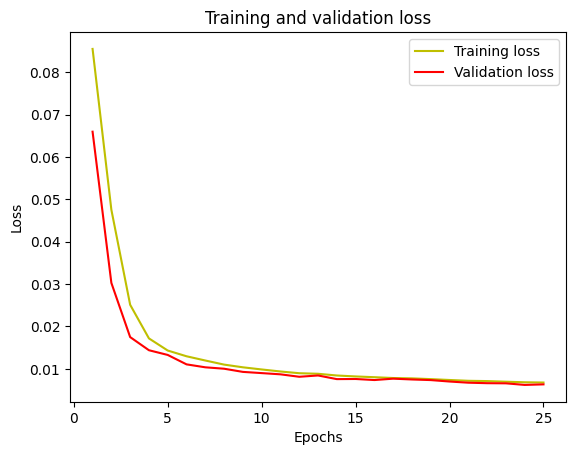

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])

2/2 [==============================] - 1s 648ms/step


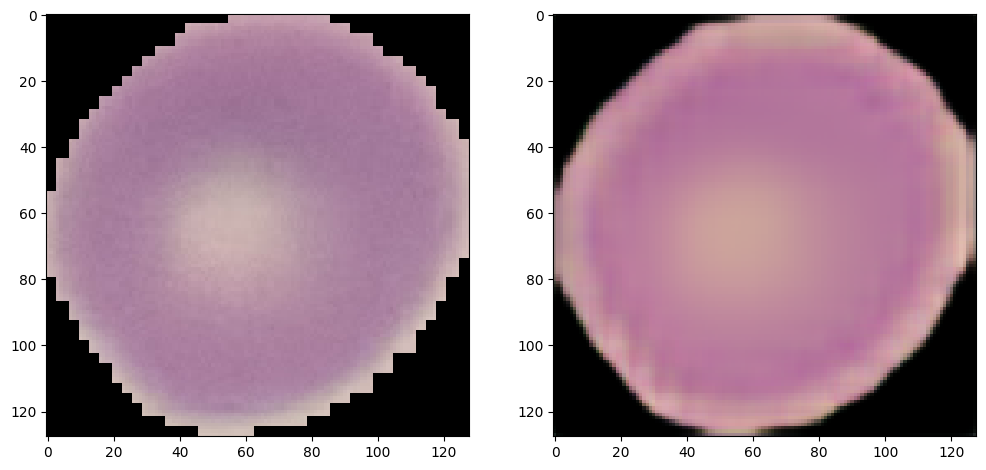

In [15]:
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [17]:
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

9/9 [==============================] - 130s 16s/step - loss: 0.0072 - mse: 0.0072
Recon. error for the validation (normal) data is:  [0.006382775027304888, 0.006382775027304888]
Recon. error for the anomaly data is:  [0.007243388332426548, 0.007243388332426548]


In [18]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 16)       

In [19]:
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

12/12 [==============================] - 11s 848ms/step


In [20]:
def calc_density_and_recon_error(batch_images):

    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):

        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))

    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))

    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [21]:
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)
print(uninfected_values)
print(anomaly_values)

1/1 [==============================] - 0s 41ms/step - loss: 0.0090 - mse: 0.0090
(2821.6951562755376, 1.3642420526593924e-12, 0.009014415170346934, 0.001718957138456294)
(1955.9163389263274, 1135.3591922465182, 0.009314198993028157, 0.0011765625047388793)


In [22]:
model.save('/content/drive/MyDrive/malaria/autoencoder_model')

In [23]:
def check_anomaly(img_path):
    density_threshold = 2700 # Set this value based on the above exercise
    reconstruction_error_threshold = 0.0089 # Set this value based on the above exercise

    # Load the image
    img = Image.open(img_path)
    img = np.array(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(img)
    plt.show()

    # Preprocess the image
    img = img / 255.
    img = img[np.newaxis, :, :, :]

    # Encode the image
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, out_vector_shape) for img in encoded_img]

    # Calculate density and reconstruction error
    density = kde.score_samples(encoded_img)[0]
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction], [[img]], batch_size=1)[0]

    # Determine if the image is an anomaly
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
    else:
        print("The image is NOT an anomaly")

<ipython-input-23-0c7c1032d6aa>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128, 128), Image.ANTIALIAS))


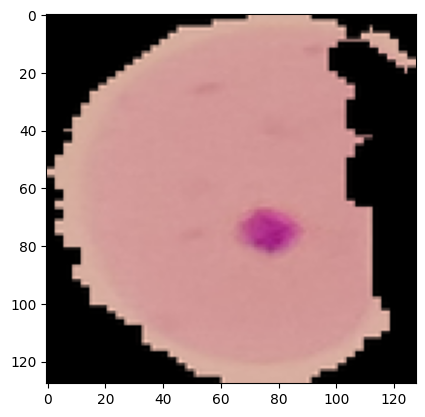

1/1 [==============================] - 0s 72ms/step - loss: 0.0104 - mse: 0.0104
The image is an anomaly


<ipython-input-23-0c7c1032d6aa>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128, 128), Image.ANTIALIAS))


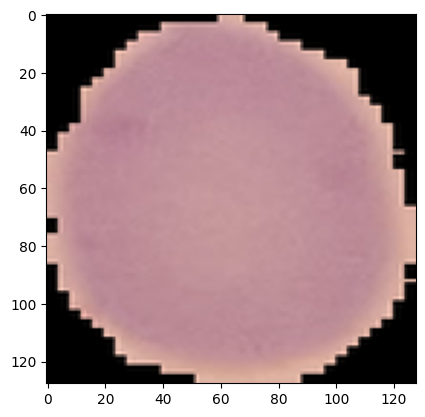

1/1 [==============================] - 0s 53ms/step - loss: 0.0079 - mse: 0.0079
The image is NOT an anomaly


In [24]:
os.chdir('/content/drive/MyDrive')

# Load file paths
para_file_paths = glob.glob('malaria/infected/abnorm/*')
uninfected_file_paths = glob.glob('malaria/test/norm/*')

# Anomaly image verification
num = random.randint(0, len(para_file_paths) - 1)
check_anomaly(para_file_paths[num])

# Good/normal image verification
num = random.randint(0, len(uninfected_file_paths) - 1)
check_anomaly(uninfected_file_paths[num])